<a href="https://colab.research.google.com/github/ChJazhiel/VAE_NBody/blob/main/Autoencoder_latent_dim_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import numpy as np

print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

tf.test.is_built_with_cuda()

#tf.debugging.set_log_device_placement(False)

2023-09-28 16:27:49.707992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 16:27:50.334592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0
Num GPUs Available:  1


2023-09-28 16:27:51.410774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 16:27:51.435667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 16:27:51.435845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

True

s-bus-pci#L344-L355
2023-09-28 16:27:51.977194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 16:27:51.977336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 16:27:51.977441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 2776 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [2]:
root_dir = "/home/isidro/Documents/github/" #content/ for Drive
image_dir =root_dir + "VAE_NBody/Projections_axis_off/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['/home/isidro/Documents/github/VAE_NBody/Projections_axis_off/D30_y_axis_off_Projection_y_density_density.png',
 '/home/isidro/Documents/github/VAE_NBody/Projections_axis_off/D33_x_axis_off_Projection_x_density_density.png']

In [3]:
len(images)

78

In [4]:
# preprocess
image_size = 256

## tf.io is an api for image processing



#TensorFlow I/O is a collection of file systems and file formats that are not available in TensorFlow's built-in
#support.

#It provides useful extra Dataset, streaming, and file system extensions, and is maintained by TensorFlow SIG-IO.

#### add a tf.crop in order to resize and add the 3 color channels


def preprocess(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    #image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image = image / 255.0
    image = tf.image.random_crop(image,  size=[256,256,4])
    image = tf.reshape(image, shape = (image_size, image_size, 4,))
    image=image[:,:,:3]
    return image

In [5]:
batch_size = 10

training_dataset = tf.data.Dataset.from_tensor_slices((images))
training_dataset = training_dataset.map(preprocess)
training_dataset = training_dataset.shuffle(1000).batch(batch_size)

2023-09-28 16:27:52.037037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 16:27:52.037227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-28 16:27:52.037482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-09-28 16:27:52.502079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [78]
	 [[{{node Placeholder/_0}}]]
2023-09-28 16:27:52.502264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [78]
	 [[{{node Placeholder/_0}}]]


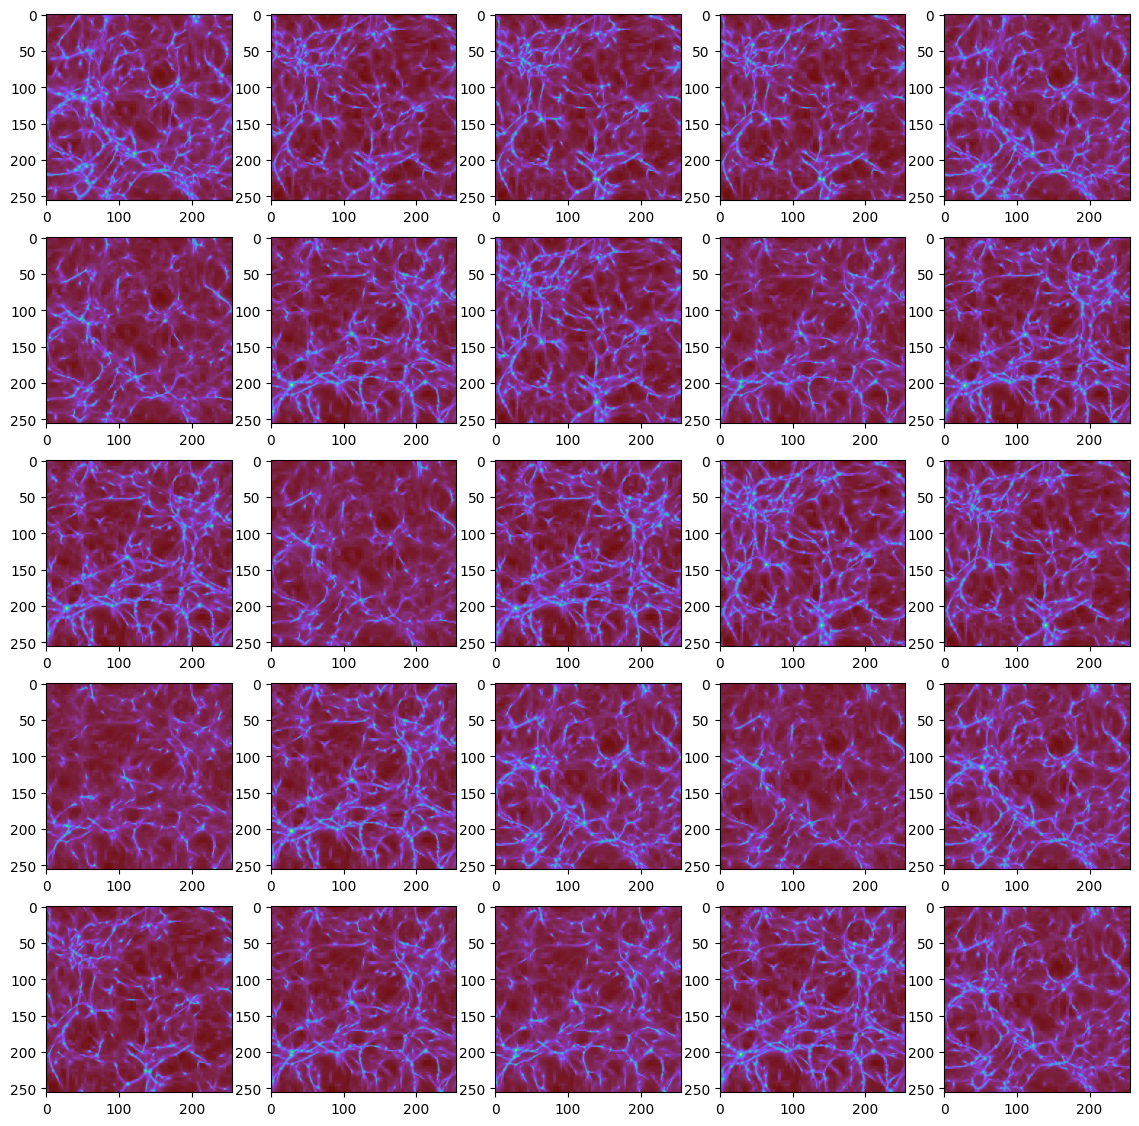

In [6]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)
sample = [image for image in sample]

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [7]:
## Necessary imports

from keras.models import Sequential, Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.optimizers import Adam


In [8]:
# Define the encoder
encoder_input = keras.Input(shape=(256, 256, 3))
x = layers.Conv2D(32, (3,3), activation="relu", strides=2, padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(8)(x)
z_log_var = layers.Dense(8)(x)



In [9]:
# Reparameterization trick to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], 8), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")


In [10]:
# Define the decoder
latent_input = keras.Input(shape=(8,))
x = layers.Dense(32 * 32 * 256, activation="relu")(latent_input)
x = layers.Reshape((32, 32, 256))(x)
x = layers.Conv2DTranspose(128, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, (3,3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), activation="relu", strides=2, padding="same")(x)
decoder_output = layers.Conv2DTranspose(3, (3,3), activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")

In [11]:
# Define the VAE as a whole
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Create the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(0.001, 0.3))


In [12]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   18496       ['conv2d[0][0]']                 
                                                                                            

In [13]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_2 (Dense)             (None, 262144)            2359296   
                                                                 
 reshape (Reshape)           (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 128)      295040    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 64)     73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 256, 256, 32)     1846

In [14]:
 vae.fit(training_dataset, epochs=10, batch_size=8)

Epoch 1/10


2023-09-28 16:27:56.346142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [78]
	 [[{{node Placeholder/_0}}]]
2023-09-28 16:27:56.346416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [78]
	 [[{{node Placeholder/_0}}]]
2023-09-28 16:27:58.986202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.5.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If build

UnimplementedError: Graph execution error:

Detected at node 'encoder/conv2d/Relu' defined at (most recent call last):
    File "/home/isidro/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/isidro/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/isidro/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/isidro/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/home/isidro/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/isidro/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_7660/138347769.py", line 1, in <module>
      vae.fit(training_dataset, epochs=10, batch_size=8)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/tmp/ipykernel_7660/27904818.py", line 12, in train_step
      z_mean, z_log_var, z = self.encoder(data)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/isidro/.local/lib/python3.10/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'encoder/conv2d/Relu'
DNN library is not found.
	 [[{{node encoder/conv2d/Relu}}]] [Op:__inference_train_function_2807]

In [ ]:
latent_dim = 8

random_vector_1 = tf.random.normal(shape = (8, latent_dim,))
random_vector_2 = tf.random.normal(shape = (8, latent_dim,))


generated_images_1 = vae.decoder.predict(random_vector_1)
generated_images_2 = vae.decoder.predict(random_vector_2)
len

In [ ]:
# Plot the generated images
n = len(generated_images_1)
rows = 8
cols = n // rows

plt.figure(figsize=(10, 10))
for i in range(n):
    #plt.subplot(rows, cols, i + 1)
    plt.imshow(generated_images_1[i])
    #plt.imshow(generated_images_2[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Plot the generated images
n = len(generated_images_1)
rows = 8
cols = n // rows

plt.figure(figsize=(10, 10))
for i in range(n):
    #plt.subplot(rows, cols, i + 1)
    #plt.imshow(generated_images_1[i])
    plt.imshow(generated_images_2[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
###Graficar media y varianza

## cambiar tamaño del filtro a 3x3 o 5x5

In [ ]:
tf.shape(z_mean)

In [ ]:
print(z_mean)

In [ ]:
print(z)

In [ ]:
latent_dim = 8

random_vector_1 = tf.random.normal(shape = (8, latent_dim,))
random_vector_2 = tf.random.normal(shape = (8, latent_dim,))


generated_images_1 = vae.decoder.predict(random_vector_1)
generated_images_2 = vae.decoder.predict(random_vector_2)

encoded = vae.encoder.predict(training_dataset)

z_mean_values = encoded[0]  # Extract z_mean values
z_log_var_values = encoded[1]  # Extract z_log_var values

# Now you can plot z_mean and z_log_var in a 2D plot
plt.scatter(z_mean_values[:, 0], z_mean_values[:, 1], c='r', label='z_mean')
plt.scatter(z_log_var_values[:, 0], z_log_var_values[:, 1], c='b', label='z_log_var')
plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Latent Space Visualization')
plt.show()